# Written text as operational data

Written text is one type of data

### Why people write?

 - To communicate: their thoughts, feelings, urgency, needs, information

### Why people communicate?

1. To express emotions
1. To share information
1. To enable or elicit an action
1. ...

### We will use written text for the purpose other than 
1. To experience emotion
1. To learn something the author intended us to learn
1. To do what the author intended us to do

### Instead, we will use written text to recognize who wrote it
 - By calculating and comparing word frequencies in written documents
 
See, for example, likely fictional story https://medium.com/@amuse/how-the-nsa-caught-satoshi-nakamoto-868affcef595

### Example 1. Dictionaries in python (associative arrays)

Plot the frequency distribution of words on a web page.

In [32]:
import requests, re
# re is a module for regular expressions: to detect various combinations of characters
import operator

# Start from a simple document
r = requests .get('http://eecs.utk.edu')

# What comes back includes headers and other HTTP stuff, get just the body of the response
t = r.text

# obtain words by splitting a string using as separator one or more (+) space/like characters (\s) 
wds = re.split('\s+',t)

# now populate a dictionary (wf)
wf = {}
for w in wds:
    if w in wf: wf [w] = wf [w] + 1
    else:  wf[w] = 1

# dictionaries can not be sorted, so lets get a sorted *list*        
wfs = sorted (wf .items(), key = operator .itemgetter (1), reverse=True)   

# lets just have no more than 15 words 
ml = min(len(wfs),15)
for i in range(1,ml,1):
    print (wfs[i][0]+"\t"+str(wfs[i][1]))  

<!DOCTYPE	1
PUBLIC	1
"-//IETF//DTD	1
2.0//EN">	1
<html><head>	1
<title>403	1
Forbidden</title>	1
</head><body>	1
<h1>Forbidden</h1>	1
<p>You	1
don't	1
have	1
permission	1
to	1


### Example 2

Lots of markup in the output, lets remove it --- 

use BeautifulSoup and nltk modules and practice some regular expressions.

In [13]:
import requests, re, nltk
from bs4 import BeautifulSoup
from nltk import clean_html
from collections import Counter
import operator

nltk.download('stopwords')

# we may not care about the usage of stop words
stop_words = nltk.corpus.stopwords.words('english') + [
 'ut', '\'re','.', ',', '--', '\'s', '?', ')', '(', ':', '\'',
 '\"', '-', '}', '{', '&', '|', u'\u2014' ]

# We most likely would like to remove html markup
def cleanHtml (html):
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')
    return soup .get_text()

# We also want to remove special characters, quotes, etc. from each word
def cleanWord (w):
    # r in r'[.,"\']' tells to treat \ as a regular character 
    # but we need to escape ' with \'
    # any character between the brackets [] is to be removed 
    wn = re.sub('[,"\.\'&\|:@>*;/=]', "", w)
    # get rid of numbers
    return re.sub('^[0-9\.]*$', "", wn)
       
# define a function to get text/clean/calculate frequency
def get_wf (URL):
    # first get the web page
    r = requests .get(URL)
    
    # Now clean
    # remove html markup
    t = cleanHtml (r .text) .lower()
    
    # split string into an array of words using any sequence of spaces "\s+" 
    wds = re .split('\s+',t)
    
    # remove periods, commas, etc stuck to the edges of words
    for i in range(len(wds)):
        wds [i] = cleanWord (wds [i])
    
    # If satisfied with results, lets go to the next step: calculate frequencies
    # We can write a loop to create a dictionary, but 
    # there is a special function for everything in python
    # in particular for counting frequencies (like function table() in R)
    wf = Counter (wds)
    
    # Remove stop words from the dictionary wf
    for k in stop_words:
        wf. pop(k, None)
        
    #how many regular words in the document?
    tw = 0
    for w in wf:
       tw += wf[w] 
        
    
    # Get ordered list
    wfs = sorted (wf .items(), key = operator.itemgetter(1), reverse=True)
    ml = min(len(wfs),15)

    #Reverse the list because barh plots items from the bottom
    return (wfs [ 0:ml ] [::-1], tw)
        
# Now populate two lists    
(wf_ee, tw_ee) = get_wf('http://www.gutenberg.org/ebooks/1342.txt.utf-8')
(wf_bu, tw_bu) = get_wf('http://www.gutenberg.org/ebooks/76.txt.utf-8')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adam\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


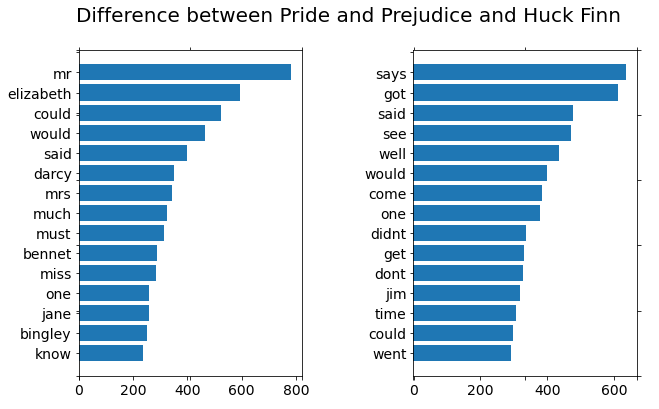

In [14]:
#Plot the results: are there striking differences in language?
import numpy as np
import pylab
import matplotlib.pyplot as plt

%matplotlib inline
def plotTwoLists (wf_ee, wf_bu, title):
    f = plt.figure (figsize=(10, 6))
    # this is painfully tedious....
    f .suptitle (title, fontsize=20)
    ax = f.add_subplot(111)
    ax .spines ['top'] .set_color ('none')
    ax .spines ['bottom'] .set_color ('none')
    ax .spines ['left'] .set_color ('none')
    ax .spines ['right'] .set_color ('none')
    ax .tick_params (labelcolor='w', top='off', bottom='off', left='off', right='off', labelsize=20)

    # Create two subplots, this is the first one
    ax1 = f .add_subplot (121)
    plt .subplots_adjust (wspace=.5)

    pos = np .arange (len(wf_ee)+1) 
    ax1 .tick_params (axis='both', which='major', labelsize=14)
    pylab .yticks (pos, [ x [0] for x in wf_ee ])
    ax1 .barh (range(len(wf_ee)), [ x [1] for x in wf_ee ], align='center')

    ax2 = f .add_subplot (122)
    ax2 .tick_params (axis='both', which='major', labelsize=14)
    pos = np .arange (len(wf_bu)+1) 
    pylab .yticks (pos, [ x [0] for x in wf_bu ])
    ax2 .barh (range (len(wf_bu)), [ x [1] for x in wf_bu ], align='center')

plotTwoLists (wf_ee, wf_bu, 'Difference between Pride and Prejudice and Huck Finn')

In [9]:
#In case Project gutenberg is blocked you can download text to your laptop and copy to the docker container via scp
#Assuming the file name you copy is pg4680.txt here is how you change the script
# Please note the option errors='replace'
# without it python invariably runs into unicode errors
f = open ('pg4680.txt', 'r', encoding="ascii", errors='replace')
    
# What comes back includes headers and other HTTP stuff, get just the body of the response
t = f.read()

# obtain words by splitting a string using as separator one or more (+) space/like characters (\s) 
wds = re.split('\s+',t)

# now populate a dictionary (wf)
wf = {}
for w in wds:
    if w in wf: wf [w] = wf [w] + 1
    else:  wf [w] = 1

# dictionaries can not be sorted, so lets get a sorted *list*        
wfs = sorted (wf .items(), key = operator .itemgetter (1), reverse=True)   

# lets just have no more than 15 words 
ml = min(len(wfs),15)
for i in range(1,ml,1):
    print (wfs[i][0]+"\t"+str(wfs[i][1]))  

and	2836
of	2676
to	2646
a	2217
in	1422
his	1205
he	928
that	920
was	823
for	798
with	797
as	672
I	505
you	497


# Assignment 1

1. Compare word frequencies between two works of a single author.
1. Compare word frequencies between works of two authors.
1. Are there some words preferred by one author but used less frequently by another author?

Extra credit

1. The frequency of a specific word, e.g., "would" should follow a binomial distribution (each regular word in a document is a trial and with probability p that word is "would". The estimate for p is N("would")/N(regular word)). Do these binomial distributions for your chosen word differ significantly between books of the same author or between authors? 

Project Gutenberg is a good source of for fiction and non-fiction.

E.g below are two most popular books from Project Gutenberg:
- Pride and Prejudice at http://www.gutenberg.org/ebooks/1342.txt.utf-8
- Adventures of Huckleberry Finn at http://www.gutenberg.org/ebooks/76.txt.utf-8

In [26]:
import requests, re, nltk
#In case your text is not on Project Gutenberg but at some other URL
#http://www.fullbooks.com/Our-World-or-The-Slaveholders-Daughter2.html
# that contains 12 parts
t = ""
for i in range(2,13):
  r = requests .get('http://www.fullbooks.com/Our-World-or-The-Slaveholders-Daughter' + str(i) + '.html')
  t = t + r.text

In [27]:
len(t)

1323653

In [26]:
import requests, re, nltk, operator
from bs4 import BeautifulSoup
from nltk import clean_html
from collections import Counter
import numpy as np
import pylab
import matplotlib.pyplot as plt

nltk.download('stopwords')

# Retrieve URLs for comparison

# "Tom Sawyer" by Mark Twain
url_ts = 'https://www.gutenberg.org/files/74/74-h/74-h.htm'
# "Huckleberry Finn" by Mark Twain
url_hf = 'https://www.gutenberg.org/files/76/76-h/76-h.htm'
# "Alice in Wonderland" by Lewis Carroll
url_aw = 'https://gutenberg.org/files/11/11-h/11-h.htm'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
stop_words = nltk.corpus.stopwords.words('english') + [
 'ut', '\'re','.', ',', '--', '\'s', '?', ')', '(', ':', '\'',
 '\"', '-', '}', '{', '&', '|', u'\u2014' ]

def cleanHtml (html):
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')
    return soup.get_text()

def cleanWord (w):
    wn = re.sub('[,"\.\'&\|:@>*;/=]', "", w)
    return re.sub('^[0-9\.]*$', "", wn)
       
def get_wf (URL):
    r = requests.get(URL)

    t = cleanHtml(r.text).lower()

    wds = re .split('\s+', t)

    for i in range(len(wds)):
        wds [i] = cleanWord(wds[i])
    
    wf = Counter(wds)

    for k in stop_words:
        wf.pop(k, None)

    tw = 0
    for w in wf:
       tw += wf[w] 

    wfs = sorted (wf.items(), key = operator.itemgetter(1), reverse = True)
    ml = min(len(wfs),15)

    return (wfs[0:ml][::-1], tw)

(wf_ts, tw_ts) = get_wf(url_ts)
(wf_hf, tw_hf) = get_wf(url_hf)
(wf_aw, tw_aw) = get_wf(url_aw)

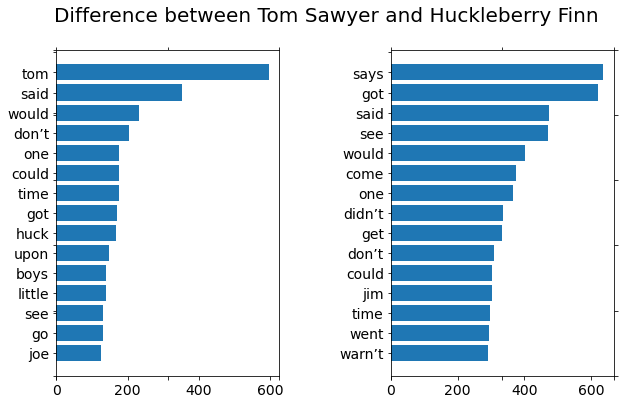

In [30]:
# PART 1 - Comparing two works by Mark Twain

%matplotlib inline
def plotTwoLists (wf_ts, wf_hf, title):
    f = plt.figure (figsize=(10, 6))
    f .suptitle (title, fontsize=20)
    ax = f.add_subplot(111)
    ax .spines ['top'].set_color ('none')
    ax .spines ['bottom'].set_color ('none')
    ax .spines ['left'].set_color ('none')
    ax .spines ['right'].set_color ('none')
    ax .tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off', labelsize=20)

    ax1 = f.add_subplot (121)
    plt.subplots_adjust (wspace=.5)

    # Tom Sawyer sublot
    pos = np.arange (len(wf_ts)+1) 
    ax1.tick_params (axis='both', which='major', labelsize=14)
    pylab.yticks (pos, [x[0] for x in wf_ts])
    ax1.barh (range(len(wf_ts)), [x[1] for x in wf_ts], align='center')

    # Huckleberry Finn subplot
    ax2 = f.add_subplot (122)
    ax2.tick_params (axis='both', which='major', labelsize=14)
    pos = np.arange (len(wf_hf)+1) 
    pylab.yticks (pos, [x[0] for x in wf_hf])
    ax2.barh (range (len(wf_hf)), [x[1] for x in wf_hf], align='center')

plotTwoLists (wf_ts, wf_hf, 'Difference between Tom Sawyer and Huckleberry Finn')

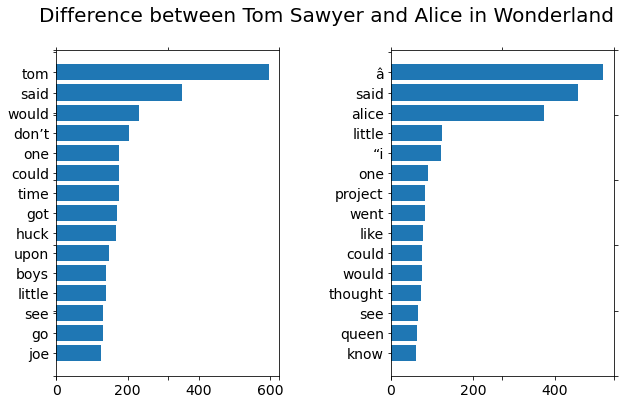

In [31]:
# PART 2 - Comparing "Tom Sawyer" by Mark Twain and "Alice in Wonderland" by Lewis Carroll

%matplotlib inline
def plotTwoLists (wf_ts, wf_hf, title):
    f = plt.figure (figsize=(10, 6))
    f.suptitle (title, fontsize=20)
    ax = f.add_subplot(111)
    ax.spines ['top'].set_color ('none')
    ax.spines ['bottom'].set_color ('none')
    ax.spines ['left'].set_color ('none')
    ax.spines ['right'].set_color ('none')
    ax.tick_params (labelcolor='w', top='off', bottom='off', left='off', right='off', labelsize=20)

    ax1 = f.add_subplot (121)
    plt.subplots_adjust (wspace=.5)

    # Tom Sawyer sublot
    pos = np.arange(len(wf_ts)+1) 
    ax1.tick_params(axis='both', which='major', labelsize=14)
    pylab.yticks(pos, [x[0] for x in wf_ts])
    ax1.barh(range(len(wf_ts)), [x[1] for x in wf_ts], align='center')

    # Alice in Wonderland subplot
    ax2 = f.add_subplot (122)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    pos = np.arange(len(wf_aw)+1) 
    pylab.yticks(pos, [x[0] for x in wf_aw])
    ax2.barh(range (len(wf_aw)), [x[1] for x in wf_aw], align='center')

plotTwoLists (wf_ts, wf_aw, 'Difference between Tom Sawyer and Alice in Wonderland')

**PART 3**

"Tom Sawyer" and "Alice in Wonderland" were published less than a decade apart from one another, but the language between the two novels appears relatively similar. As expected, both pieces use names of characters (Tom, Alice, Huck, Queen) as often as needed. Twain seems to use more auxillary verbs such as "would" and "could" than Carroll, which may be due to how the stories are told. Tom Sawyer's actions are interpreted from an outside perspective, using those words only as implications of what is happening, while Carroll uses more direct verbs to show active knowledge of what is happening to Alice.